In [2]:
import ROOT
from ROOT import TMVA

In [3]:
ninput = 30
# ninput=10
ntime = 10
# batchSize = 100
batchSize = 100
maxepochs = 20

use_type = 1

nTotEvts = 10000 # total events to be generated for signal or background

useKeras = True


useTMVA_RNN = True
useTMVA_DNN = True
useTMVA_BDT = False

In [4]:

rnn_types = ["RNN", "LSTM", "GRU"]
use_rnn_type = [1, 1, 1]
if (use_type >=0 & use_type < 3) :
      use_rnn_type = [0,0,0]
      use_rnn_type[use_type] = 1;

In [5]:
archString = "CPU"
writeOutputFile = True

In [6]:
rnn_type = "RNN"

In [7]:
ROOT.TMVA.Tools.Instance()
ROOT.TMVA.PyMethodBase.PyInitialize()

In [8]:
num_threads = 0   # use by default all threads
#    do enable MT running
if (num_threads >= 0):
    ROOT.EnableImplicitMT(num_threads)
    if (num_threads > 0):
        ROOT.gSystem.Setenv("OMP_NUM_THREADS", num_threads)
    else:
      ROOT.gSystem.Setenv("OMP_NUM_THREADS", "1")


print("Running with nthreads  = " + str(ROOT.GetThreadPoolSize()) + "\n" )

inputFileName = "time_data_t10_d30.root"

fileExist = ROOT.gSystem.AccessPathName(inputFileName)

#if file does not exists create it
if (fileExist==None):
    MakeTimeData(nTotEvts,ntime, ninput)

inputFile = ROOT.TFile.Open(inputFileName)
if (inputFile==None):
    Error("TMVA_RNN_Classification", "Error opening input file %s - exit", inputFileName.Data())

Running with nthreads  = 4



In [9]:
print("--- RNNClassification  : Using input file: " + inputFile.GetName()+"\n")

#   Create a ROOT output file where TMVA will store ntuples, histograms, etc.
outfileName = "data_RNN_"+ archString +".root"

if (writeOutputFile):
    outputFile = ROOT.TFile.Open(outfileName, "RECREATE")

#  Creating the factory object
factory = ROOT.TMVA.Factory("TMVAClassification", outputFile,"!V:!Silent:Color:DrawProgressBar:Transformations=None:!Correlations:"+"AnalysisType=Classification:ModelPersistence")

--- RNNClassification  : Using input file: time_data_t10_d30.root



In [10]:
dataloader =ROOT.TMVA.DataLoader("dataset")

signalTree = inputFile.Get("sgn")
background = inputFile.Get("bkg")

signalTree.Print()
nvar = ninput * ntime

# add variables - use new AddVariablesArray function
for i in range(ntime):
    varName = "vars_time"+str(i)
    dataloader.AddVariablesArray(varName,ninput,'F')

dataloader.AddSignalTree(signalTree, 1.0)
dataloader.AddBackgroundTree(background, 1.0)

# check given input
datainfo = dataloader.GetDataSetInfo()
vars = datainfo.GetListOfVariables()
print("number of variables is " + str(vars.size())+ "\n")
for v in vars:
    print(str(v)+"\n")

nTrainSig = 0.8 * nTotEvts
nTrainBkg = 0.8 *  nTotEvts

#build the string options for DataLoader::PrepareTrainingAndTestTree
prepareOptions = "nTrain_Signal="+str(nTrainSig)+":nTrain_Background="+str(nTrainBkg)+":SplitMode=Random:SplitSeed=100:NormMode=NumEvents:!V:!CalcCorrelations"

number of variables is 300

vars_time0[0]

vars_time0[1]

vars_time0[2]

vars_time0[3]

vars_time0[4]

vars_time0[5]

vars_time0[6]

vars_time0[7]

vars_time0[8]

vars_time0[9]

vars_time0[10]

vars_time0[11]

vars_time0[12]

vars_time0[13]

vars_time0[14]

vars_time0[15]

vars_time0[16]

vars_time0[17]

vars_time0[18]

vars_time0[19]

vars_time0[20]

vars_time0[21]

vars_time0[22]

vars_time0[23]

vars_time0[24]

vars_time0[25]

vars_time0[26]

vars_time0[27]

vars_time0[28]

vars_time0[29]

vars_time1[0]

vars_time1[1]

vars_time1[2]

vars_time1[3]

vars_time1[4]

vars_time1[5]

vars_time1[6]

vars_time1[7]

vars_time1[8]

vars_time1[9]

vars_time1[10]

vars_time1[11]

vars_time1[12]

vars_time1[13]

vars_time1[14]

vars_time1[15]

vars_time1[16]

vars_time1[17]

vars_time1[18]

vars_time1[19]

vars_time1[20]

vars_time1[21]

vars_time1[22]

vars_time1[23]

vars_time1[24]

vars_time1[25]

vars_time1[26]

vars_time1[27]

vars_time1[28]

vars_time1[29]

vars_time2[0]

vars_time2[1]

va

In [11]:
# Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";

dataloader.PrepareTrainingAndTestTree(mycuts, mycutb, prepareOptions)

print("prepared DATA LOADER " )

prepared DATA LOADER 


In [12]:


if (useTMVA_RNN):
    for i in range(3):
        if (use_rnn_type[i]==None):
            continue
        rnn_type = str(rnn_types[i])

#          define the inputlayout string for RNN
#          the input data should be organize as   following:
#          input layout for RNN:    time x ndim

        inputLayoutString = "InputLayout="+str(ntime)+"|"+str(ninput)

        # Define RNN layer layout
        # it should be   LayerType (RNN or LSTM or GRU) |  number of units | number of inputs | time steps | remember output (typically no=0 | return full sequence
        rnnLayout = str(rnn_type) + "|10|"+ str(ninput) + "|" + str(ntime) + "|0|1"

        #        add after RNN a reshape layer (needed top flatten the output) and a dense layer with 64 units and a last one
        #        Note the last layer is linear because  when using Crossentropy a Sigmoid is applied already
        layoutString ="Layout=" + rnnLayout + ",RESHAPE|FLAT,DENSE|64|TANH,LINEAR"

        #Defining Training strategies. Different training strings can be concatenate. Use however only one
        trainingString1 = "LearningRate=1e-3,Momentum=0.0,Repetitions=1,"+"ConvergenceSteps=5,BatchSize="+str(batchSize)+",TestRepetitions=1,"+"WeightDecay=1e-2,Regularization=None,MaxEpochs="+str(maxepochs
        )+","+"Optimizer=ADAM,DropConfig=0.0+0.+0.+0."

        trainingStrategyString="TrainingStrategy="
        trainingStrategyString += trainingString1; # + "|" + trainingString2

        # Define the full RNN Noption string adding the final options for all network
        rnnOptions = "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"+"WeightInitialization=XAVIERUNIFORM:ValidationSize=0.2:RandomSeed=1234"
        rnnOptions +=  ":" + inputLayoutString
        rnnOptions +=  ":" + layoutString
        rnnOptions +=  ":" + trainingStrategyString
        rnnOptions +=  ":" + "Architecture=" + str(archString)

        rnnName = "TMVA_" + rnn_type
        factory.BookMethod(dataloader, TMVA.Types.kDL, rnnName, rnnOptions)

Factory                  : Booking method: TMVA_RNN
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIERUNIFORM:ValidationSize=0.2:RandomSeed=1234:InputLayout=10|30:Layout=RNN|10|30|10|0|1,RESHAPE|FLAT,DENSE|64|TANH,LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.0,Repetitions=1,ConvergenceSteps=5,BatchSize=100,TestRepetitions=1,WeightDecay=1e-2,Regularization=None,MaxEpochs=20,Optimizer=ADAM,DropConfig=0.0+0.+0.+0.:Architecture=CPU"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=

In [13]:
if (useTMVA_DNN):
#    Method DL with Dense Layer
    inputLayoutString = "InputLayout=1|1|" + str(ntime * ninput)

    layoutString = "Layout=DENSE|64|TANH,DENSE|TANH|64,DENSE|TANH|64,LINEAR"
#   Training strategies.
    trainingString1 = "LearningRate=1e-3,Momentum=0.0,Repetitions=1,"+"ConvergenceSteps=10,BatchSize=256,TestRepetitions=1,"+"WeightDecay=1e-4,Regularization=None,MaxEpochs=20"+"DropConfig=0.0+0.+0.+0.,Optimizer=ADAM"
    trainingStrategyString = "TrainingStrategy="
    trainingStrategyString += trainingString1 # + "|" + trainingString2

      # General Options.
    dnnOptions = "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"+"WeightInitialization=XAVIER:RandomSeed=0" 

    dnnOptions +=  ":" + inputLayoutString
    dnnOptions +=  ":" + layoutString
    dnnOptions +=  ":" + trainingStrategyString
    dnnOptions +=  ":" + "Architecture=" + str(archString)


    dnnName = "TMVA_DNN"
    factory.BookMethod(dataloader, TMVA.Types.kDL, dnnName, dnnOptions)
   


Factory                  : Booking method: TMVA_DNN
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIER:RandomSeed=0:InputLayout=1|1|300:Layout=DENSE|64|TANH,DENSE|TANH|64,DENSE|TANH|64,LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.0,Repetitions=1,ConvergenceSteps=10,BatchSize=256,TestRepetitions=1,WeightDecay=1e-4,Regularization=None,MaxEpochs=20DropConfig=0.0+0.+0.+0.,Optimizer=ADAM:Architecture=CPU"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIER:RandomSeed=0:InputLayo

In [14]:
import torch
from torch import nn

# Define model

# Custom Reshape Layer
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,1,10,30)

# CNN Model Definition
net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 10, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(10),
    nn.Conv2d(10, 10, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(10*5*15, 300),
    nn.ReLU(),
    nn.Linear(300, 2),
    nn.Sigmoid()
    )

# Construct loss function and Optimizer.
criterion = nn.BCELoss()
optimizer = torch.optim.Adam


def fit(model, train_loader, val_loader, num_epochs, batch_size, optimizer, criterion, save_best, scheduler):
    trainer = optimizer(model.parameters(), lr=0.01)
    schedule, schedulerSteps = scheduler
    best_val = None

    # Setup GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    for epoch in range(num_epochs):
        # Training Loop
        # Set to train mode
        model.train()
        running_train_loss = 0.0
        running_val_loss = 0.0
        for i, (X, y) in enumerate(train_loader):
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            output = model(X)
            target = y
            train_loss = criterion(output, target)
            train_loss.backward()
            trainer.step()

            # print train statistics
            running_train_loss += train_loss.item()
            if i % 4 == 3:    # print every 4 mini-batches
                print(f"[{epoch+1}, {i+1}] train loss: {running_train_loss / 4 :.3f}")
                running_train_loss = 0.0

        if schedule:
            schedule(optimizer, epoch, schedulerSteps)

        # Validation Loop
        # Set to eval mode
        model.eval()
        with torch.no_grad():
            for i, (X, y) in enumerate(val_loader):
                X, y = X.to(device), y.to(device)
                output = model(X)
                target = y
                val_loss = criterion(output, target)
                running_val_loss += val_loss.item()

            curr_val = running_val_loss / len(val_loader)
            if save_best:
               if best_val==None:
                   best_val = curr_val
               best_val = save_best(model, curr_val, best_val)

            # print val statistics per epoch
            print(f"[{epoch+1}] val loss: {curr_val :.3f}")
            running_val_loss = 0.0

    print(f"Finished Training on {epoch+1} Epochs!")

    return model


def predict(model, test_X, batch_size=100):
    # Set to eval mode

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    model.eval()


    test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_X))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    predictions = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            X = data[0].to(device)
            outputs = model(X)
            predictions.append(outputs)
        preds = torch.cat(predictions)

    return preds.cpu().numpy()


load_model_custom_objects = {"optimizer": optimizer, "criterion": criterion, "train_func": fit, "predict_func": predict}

# Store model to file
m = torch.jit.script(net)
torch.jit.save(m,"PyTorchModelRNN.pt")


In [15]:
factory.BookMethod(dataloader, ROOT.TMVA.Types.kPyTorch, "PyTorch","H:!V:VarTransform=None:FilenameModel=PyTorchModelRNN.pt:" + "FilenameTrainedModel=PyTorchTrainedModelRNN.pt:NumEpochs=20:BatchSize=100")    

custom objects for loading model :  {'optimizer': <class 'torch.optim.adam.Adam'>, 'criterion': BCELoss(), 'train_func': <function fit at 0x7ff54b9ff280>, 'predict_func': <function predict at 0x7ff54b9ff310>}


Factory                  : Booking method: PyTorch
                         : 
                         : Using PyTorch - setting special configuration options 
                         : Using PyTorch version 1
                         :  Setup PyTorch Model 
                         : Loaded pytorch train function: 
                         : Loaded pytorch optimizer: 
                         : Loaded pytorch loss function: 
                         : Loaded pytorch predict function: 
                         : Load model from file: PyTorchModelRNN.pt


In [16]:
# Train all methods
factory.TrainAllMethods()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Reshape)
  (1): RecursiveScriptModule(original_name=Conv2d)
  (2): RecursiveScriptModule(original_name=ReLU)
  (3): RecursiveScriptModule(original_name=BatchNorm2d)
  (4): RecursiveScriptModule(original_name=Conv2d)
  (5): RecursiveScriptModule(original_name=ReLU)
  (6): RecursiveScriptModule(original_name=MaxPool2d)
  (7): RecursiveScriptModule(original_name=Flatten)
  (8): RecursiveScriptModule(original_name=Linear)
  (9): RecursiveScriptModule(original_name=ReLU)
  (10): RecursiveScriptModule(original_name=Linear)
  (11): RecursiveScriptModule(original_name=Sigmoid)
)
[1, 4] train loss: 1.246
[1, 8] train loss: 0.732
[1, 12] train loss: 0.675
[1, 16] train loss: 0.660
[1, 20] train loss: 0.680
[1, 24] train loss: 0.584
[1, 28] train loss: 0.639
[1, 32] train loss: 0.517
[1, 36] train loss: 0.514
[1, 40] train loss: 0.494
[1, 44] train loss: 0.478
[1, 48] train loss: 0.428
[1, 52] train loss:

In [17]:
print("nthreads  = "+ str(ROOT.GetThreadPoolSize()) + "\n")

# Evaluate all MVAs using the set of test events
factory.TestAllMethods()

nthreads  = 4

custom objects for loading model :  {'optimizer': <class 'torch.optim.adam.Adam'>, 'criterion': BCELoss(), 'train_func': <function fit at 0x7ff54b9ff280>, 'predict_func': <function predict at 0x7ff54b9ff310>}
Factory                  : Test all methods
Factory                  : Test method: TMVA_RNN for Classification performance
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
TMVA_RNN                 : [dataset] : Evaluation of TMVA_RNN on testing sample (4000 events)
                         : Elapsed time for evaluation of 4000 events: 0.0704 sec       
Factory                  : Test method: TMVA_LSTM for Classification performance
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
TMVA_LSTM                : [dataset] : Evaluation of TMVA_LSTM on testing sample (4000 e

In [18]:
# Evaluate and compare performance of all configured MVAs
factory.EvaluateAllMethods()
#  check method


Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: TMVA_RNN
                         : 
TMVA_RNN                 : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
                         : Dataset[dataset] :  variable plots are not produces ! The number of variables is 300 , it is larger than 200
Factory                  : Evaluate classifier: TMVA_LSTM
                         : 
TMVA_LSTM                : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
                         : Dataset[dataset] :  variable plots are not produces ! The number of variables is 300 , it is larger 

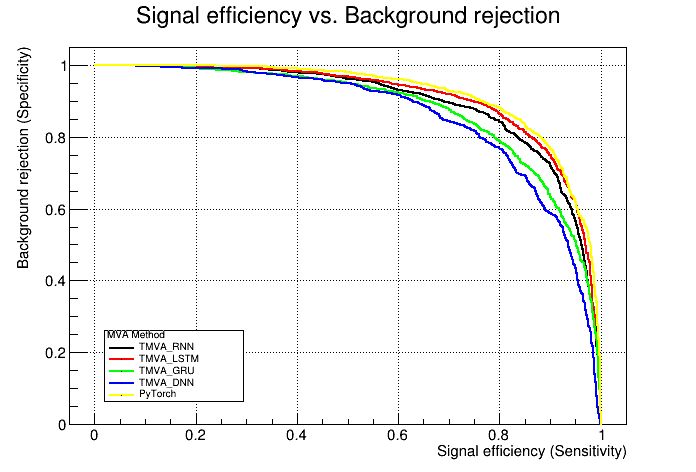

In [19]:
#  plot ROC curve
c1 = factory.GetROCCurve(dataloader)
c1.Draw() 

In [20]:

if (outputFile):
    outputFile.Close()